# UrbanPulse - Traffic Flow Analysis in Paris

## 1. Introduction
UrbanPulse is a project aimed at analyzing traffic flow patterns in Paris using open data. 

The goal is to identify congestion zones and peak traffic hours and to propose data-driven recommendations to improve traffic management. 

This notebook will detail the process step by step.

## 2. Data Collection
In this section, we will collect and import the necessary datasets for the project.


In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox
import requests




The road network will be used to analyze traffic density in different areas of Paris.

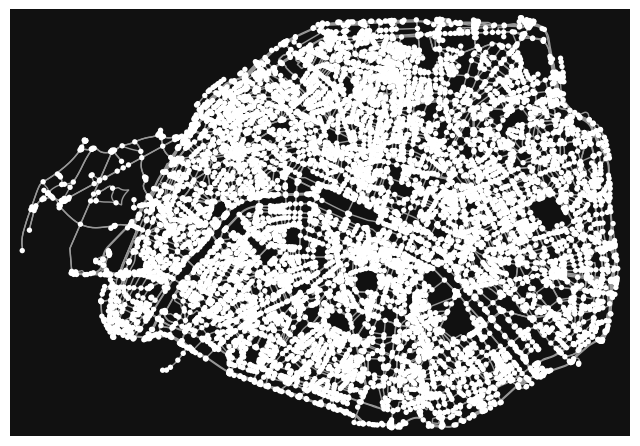

In [2]:
# Download the road network for Paris using OpenStreetMap API
G = ox.graph_from_place('Paris, France', network_type='drive')

# Visualize the road network
ox.plot_graph(G)

# Saving the graph as graphml file for later use 
ox.save_graphml(G, filepath='paris_routier.graphml')


the data set available for a year being very heavy, I decided to work on a data set of a week.
the csv file can be found on the following [Link](https://opendata.paris.fr/explore/dataset/comptages-routiers-permanents/export/?disjunctive.libelle&disjunctive.libelle_nd_amont&disjunctive.libelle_nd_aval&disjunctive.etat_trafic)

In [3]:
import pandas as pd

# charging the csv files into datafrane
file_path_comptage = "/Users/happiste/Documents/UrbanPulse/comptages-routiers-permanents.csv" 
file_path_ref = "/Users/happiste/Documents/UrbanPulse/referentiel-comptages-routiers.csv" 
comptages_df = pd.read_csv(file_path_comptage, delimiter=";")
referentiel_df = pd.read_csv(file_path_ref, delimiter=";")

# checking the data
print(f'>>>> {comptages_df.head()}')
print(f"Nombre de lignes pour la semaine : {len(comptages_df)}\n")

print('------------------------------------------------------')

print(f'>>>> {referentiel_df.head()}')
print(f"Nombre de lignes pour la semaine : {len(referentiel_df)}\n")





>>>>    Identifiant arc        Libelle  Date et heure de comptage  Débit horaire  \
0             4010   Av_de_Clichy  2024-12-04T14:00:00+01:00          223.0   
1             1884   Av_de_Clichy  2024-12-04T14:00:00+01:00          174.0   
2             1883   Av_de_Clichy  2024-12-04T14:00:00+01:00          102.0   
3             4047   Av_de_Clichy  2024-12-04T14:00:00+01:00            NaN   
4             1889  Av_de_St_Ouen  2024-12-04T14:00:00+01:00            NaN   

   Taux d'occupation Etat trafic  Identifiant noeud amont  \
0           13.72667      Fluide                     2037   
1            3.46000      Fluide                     2039   
2                NaN     Inconnu                     2039   
3           21.47556  Pré-saturé                     2043   
4                NaN     Inconnu                     2044   

       Libelle noeud amont  Identifiant noeud aval  \
0      Av_de_Clichy-Moquet                    2029   
1    Av_de_Clichy-Legendre                   

## 3. Data Exploration (EDA)
Here, we will explore the structure of the data and extract initial insights.

### 3.1 EDA for Comptage_df

In [4]:
#have an overview of the dataset comptage_df to understand its structure

print(comptages_df.head())
print(comptages_df.tail())

   Identifiant arc        Libelle  Date et heure de comptage  Débit horaire  \
0             4010   Av_de_Clichy  2024-12-04T14:00:00+01:00          223.0   
1             1884   Av_de_Clichy  2024-12-04T14:00:00+01:00          174.0   
2             1883   Av_de_Clichy  2024-12-04T14:00:00+01:00          102.0   
3             4047   Av_de_Clichy  2024-12-04T14:00:00+01:00            NaN   
4             1889  Av_de_St_Ouen  2024-12-04T14:00:00+01:00            NaN   

   Taux d'occupation Etat trafic  Identifiant noeud amont  \
0           13.72667      Fluide                     2037   
1            3.46000      Fluide                     2039   
2                NaN     Inconnu                     2039   
3           21.47556  Pré-saturé                     2043   
4                NaN     Inconnu                     2044   

       Libelle noeud amont  Identifiant noeud aval  \
0      Av_de_Clichy-Moquet                    2029   
1    Av_de_Clichy-Legendre                    2040

In [5]:
print(comptages_df.shape)
print(comptages_df.info())
print(comptages_df.isnull().sum())
print(comptages_df.describe())



(563598, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563598 entries, 0 to 563597
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Identifiant arc            563598 non-null  int64  
 1   Libelle                    563598 non-null  object 
 2   Date et heure de comptage  563598 non-null  object 
 3   Débit horaire              279742 non-null  float64
 4   Taux d'occupation          288568 non-null  float64
 5   Etat trafic                563598 non-null  object 
 6   Identifiant noeud amont    563598 non-null  int64  
 7   Libelle noeud amont        563598 non-null  object 
 8   Identifiant noeud aval     563598 non-null  int64  
 9   Libelle noeud aval         563598 non-null  object 
 10  Etat arc                   563598 non-null  object 
 11  Date debut dispo data      558117 non-null  object 
 12  Date fin dispo data        558117 non-null  object 
 13  geo_point_2d    

In [6]:
#Analysis of columns and their contents
print(comptages_df.columns)

#Categorical Columns: Displays unique values ​​for non-numeric columns
for col in comptages_df.select_dtypes(include='object').columns:
    print(f"{col}: {comptages_df[col].unique()}")



Index(['Identifiant arc', 'Libelle', 'Date et heure de comptage',
       'Débit horaire', 'Taux d'occupation', 'Etat trafic',
       'Identifiant noeud amont', 'Libelle noeud amont',
       'Identifiant noeud aval', 'Libelle noeud aval', 'Etat arc',
       'Date debut dispo data', 'Date fin dispo data', 'geo_point_2d',
       'geo_shape'],
      dtype='object')
Libelle: ['Av_de_Clichy' 'Av_de_St_Ouen' 'Amsterdam' 'Bd_de_Clichy'
 'Bd_des_Batignolles' 'Bd_Batignolles' 'SE_St_Ouen' 'PI_Andre_Brechet'
 'SI_Clichy' 'PI_Clichy' 'Clichy' 'Peletier' 'Maubeuge' 'La_Fayette'
 'Chateaudun' 'Bd_Haussmann' 'Bd_des_Italiens' 'Bd_des_Capucines' 'Halevy'
 '4_Septembre' 'Reaumur' 'PE_Heliport' 'Quai_Anatole_France'
 'Bd_Kellermann' 'Rivoli' 'Bd_Berthier' 'Quai_Francois_Mauriac'
 'Av_Pte_Asnieres' 'Av_Friedland' 'Av_de_Friedland' 'PE_Courcelles'
 'PE_Asnieres' 'SI_Asnieres' 'PI_Asnieres' 'Av_Paul_Adam' 'Courcelles'
 'Av_de_Villiers' 'Av_Champs_Elysees' 'Av_des_Champs_Elysees'
 'Bd_Malesherbes' 'Av_des_T

In [7]:
num_col = comptages_df.select_dtypes(include=['number']).columns
num_stats = comptages_df[num_col].describe()
print(num_stats)


       Identifiant arc  Débit horaire  Taux d'occupation  \
count    563598.000000  279742.000000      288568.000000   
mean       3576.051308     615.596250           7.821266   
std        2310.696061    1046.197451          11.048534   
min           1.000000       0.000000           0.000000   
25%        1176.000000     150.000000           1.556670   
50%        4526.500000     312.000000           3.916670   
75%        5510.000000     560.000000           8.945560   
max        7281.000000    8054.000000          99.997780   

       Identifiant noeud amont  Identifiant noeud aval  
count            563598.000000           563598.000000  
mean               1771.693494             1771.074447  
std                1189.347775             1189.061932  
min                   0.000000                0.000000  
25%                 556.000000              559.000000  
50%                2266.500000             2266.500000  
75%                2812.000000             2811.000000  
max

In [8]:
#Identify and quantify duplicate lines.
print(f"Number of duplicates : {comptages_df.duplicated().sum()}")


Number of duplicates : 0


In [9]:
#Identify columns or rows where data is missing.
missing_values = comptages_df.isnull().mean() * 100
print(missing_values)



Identifiant arc               0.000000
Libelle                       0.000000
Date et heure de comptage     0.000000
Débit horaire                50.364976
Taux d'occupation            48.798967
Etat trafic                   0.000000
Identifiant noeud amont       0.000000
Libelle noeud amont           0.000000
Identifiant noeud aval        0.000000
Libelle noeud aval            0.000000
Etat arc                      0.000000
Date debut dispo data         0.972502
Date fin dispo data           0.972502
geo_point_2d                  0.972502
geo_shape                     0.972502
dtype: float64


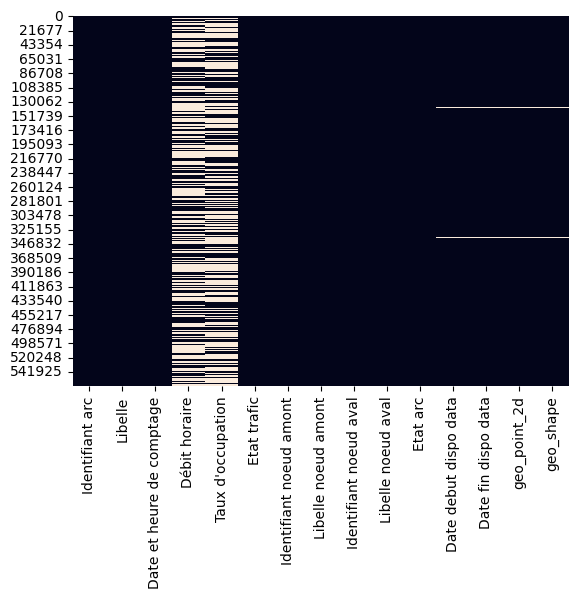

In [10]:
#visualizing missing value.

import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(comptages_df.isnull(), cbar=False)
plt.show()


### 3.2 EDA for referentiel_df

In [12]:
#have an overview of the dataset referentiel_df to understand its structure

print(referentiel_df.head())
print(referentiel_df.tail())


   Identifiant arc      Date debut dispo data        Date fin dispo data  \
0              913  1996-10-03T04:00:00+02:00  2023-01-01T02:00:00+01:00   
1             5221  1996-10-25T04:00:00+02:00  2023-01-01T02:00:00+01:00   
2              852  1996-10-03T04:00:00+02:00  2023-01-01T02:00:00+01:00   
3              800  1996-10-03T04:00:00+02:00  2023-01-01T02:00:00+01:00   
4              863  1996-10-03T04:00:00+02:00  2023-01-01T02:00:00+01:00   

             Libelle  Identifiant noeud aval          Libelle noeud aval  \
0   Av_Pte_Vincennes                     514  Bd_Davout-Pte_de_Vincennes   
1  Bd_Gouvion_St_Cyr                    2751           14_Gouvion_St_Cyr   
2         Bd_Massena                     490             Bd_Massena-Pean   
3      Bd_Kellermann                     458     Bd_Kellermann-Gouthiere   
4         Bd_Massena                     496  Bd_Massena_Porte_de_France   

   Identifiant noeud amont      Libelle noeud amont  \
0                      523  Pte

In [34]:
print(referentiel_df.shape)
print(referentiel_df.info())
print(referentiel_df.isnull().sum())
print(referentiel_df.describe())


(3739, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3739 entries, 0 to 3738
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Identifiant arc          3739 non-null   int64 
 1   Date debut dispo data    3739 non-null   object
 2   Date fin dispo data      3739 non-null   object
 3   Libelle                  3739 non-null   object
 4   Identifiant noeud aval   3739 non-null   int64 
 5   Libelle noeud aval       3739 non-null   object
 6   Identifiant noeud amont  3739 non-null   int64 
 7   Libelle noeud amont      3739 non-null   object
 8   geo_point_2d             3739 non-null   object
 9   geo_shape                3739 non-null   object
dtypes: int64(3), object(7)
memory usage: 292.2+ KB
None
Identifiant arc            0
Date debut dispo data      0
Date fin dispo data        0
Libelle                    0
Identifiant noeud aval     0
Libelle noeud aval         0
Identifiant noe

In [13]:
#Analysis of columns and their contents
print(referentiel_df.columns)

#Categorical Columns: Displays unique values ​​for non-numeric columns
for col in referentiel_df.select_dtypes(include='object').columns:
    print(f"{col}: {referentiel_df[col].unique()}")

Index(['Identifiant arc', 'Date debut dispo data', 'Date fin dispo data',
       'Libelle', 'Identifiant noeud aval', 'Libelle noeud aval',
       'Identifiant noeud amont', 'Libelle noeud amont', 'geo_point_2d',
       'geo_shape'],
      dtype='object')
Date debut dispo data: ['1996-10-03T04:00:00+02:00' '1996-10-25T04:00:00+02:00'
 '1996-10-10T04:00:00+02:00' '1996-10-09T04:00:00+02:00'
 '1996-10-21T04:00:00+02:00' '1997-01-09T02:00:00+01:00'
 '1997-10-10T04:00:00+02:00' '1996-12-10T02:00:00+01:00'
 '1996-10-18T04:00:00+02:00' '1996-10-28T02:00:00+01:00'
 '1996-10-15T04:00:00+02:00' '1996-10-14T04:00:00+02:00'
 '1997-10-14T04:00:00+02:00' '1996-10-17T04:00:00+02:00'
 '1996-10-16T04:00:00+02:00' '1997-01-10T02:00:00+01:00'
 '1997-01-20T02:00:00+01:00' '1997-03-07T02:00:00+01:00'
 '1997-03-13T02:00:00+01:00' '2000-10-27T04:00:00+02:00'
 '2000-10-26T04:00:00+02:00' '2001-07-18T04:00:00+02:00'
 '2000-04-28T04:00:00+02:00' '2006-11-14T02:00:00+01:00'
 '1997-01-08T02:00:00+01:00' '2007-07

In [14]:
num_col = referentiel_df.select_dtypes(include=['number']).columns
num_stats = referentiel_df[num_col].describe()
print(num_stats)


       Identifiant arc  Identifiant noeud aval  Identifiant noeud amont
count      3739.000000             3739.000000              3739.000000
mean       3629.755282             1802.495320              1808.647499
std        2324.857581             1193.524019              1197.547906
min           1.000000                0.000000                 0.000000
25%        1227.500000              575.000000               574.500000
50%        4509.000000             2308.000000              2310.000000
75%        5558.500000             2831.500000              2845.000000
max        7219.000000             3737.000000              3737.000000


In [15]:
#Identify and quantify duplicate lines.
print(f"Number of duplicates : {referentiel_df.duplicated().sum()}")

Number of duplicates : 0


In [16]:
#Identify columns or rows where data is missing.
missing_values = referentiel_df.isnull().mean() * 100
print(missing_values)

Identifiant arc            0.0
Date debut dispo data      0.0
Date fin dispo data        0.0
Libelle                    0.0
Identifiant noeud aval     0.0
Libelle noeud aval         0.0
Identifiant noeud amont    0.0
Libelle noeud amont        0.0
geo_point_2d               0.0
geo_shape                  0.0
dtype: float64


## 4. Data Cleaning
This section covers the cleaning and preparation of the datasets for analysis.

As we could see in the EDA for the first data set : 
- 2 columns with about 50% missing values.
- 4 columns with 0.97% missing values 
- 0 duplicates.

The second DataSet
- No missing values 
- No duplicates 

The Hourly Flow and Occupancy Rate columns are key indicators for understanding traffic density and congestion areas.

Removing them or ignoring missing values ​​could reduce the quality of insights and geospatial visualization.
Typically, traffic information reflects regular movements over a short period of time (e.g., hour by hour). 
Linear interpolation offers the ability to produce reliable estimates without incorporating bias.

and for the 4 columns with 0.97% missing values il will simply remove it. 


In [17]:
comptages_df['Débit horaire'] = comptages_df['Débit horaire'].interpolate(method='linear')
comptages_df['Taux d\'occupation'] = comptages_df['Taux d\'occupation'].interpolate(method='linear')


In [18]:
missing_values = comptages_df.isnull().mean() * 100
print(missing_values)

Identifiant arc              0.000000
Libelle                      0.000000
Date et heure de comptage    0.000000
Débit horaire                0.000000
Taux d'occupation            0.000000
Etat trafic                  0.000000
Identifiant noeud amont      0.000000
Libelle noeud amont          0.000000
Identifiant noeud aval       0.000000
Libelle noeud aval           0.000000
Etat arc                     0.000000
Date debut dispo data        0.972502
Date fin dispo data          0.972502
geo_point_2d                 0.972502
geo_shape                    0.972502
dtype: float64


In [19]:
#droping the last missing values 

comptages_df.dropna(inplace=True)
missing_values = comptages_df.isnull().mean() * 100
print(missing_values)


Identifiant arc              0.0
Libelle                      0.0
Date et heure de comptage    0.0
Débit horaire                0.0
Taux d'occupation            0.0
Etat trafic                  0.0
Identifiant noeud amont      0.0
Libelle noeud amont          0.0
Identifiant noeud aval       0.0
Libelle noeud aval           0.0
Etat arc                     0.0
Date debut dispo data        0.0
Date fin dispo data          0.0
geo_point_2d                 0.0
geo_shape                    0.0
dtype: float64


## Data Preparation(merging)
here the merging is necessary to map traffic data.

first in need to verify the relation between the data set. 

In [20]:
#lists the common columns between the two datasets.
print(set(comptages_df.columns) & set(referentiel_df.columns))


{'Libelle noeud aval', 'geo_shape', 'Date fin dispo data', 'Identifiant noeud aval', 'Libelle', 'geo_point_2d', 'Date debut dispo data', 'Identifiant noeud amont', 'Libelle noeud amont', 'Identifiant arc'}


In [21]:
#Verifying if all the identifiant arc are present in the second data set 
print(set(comptages_df['Identifiant arc']).issubset(referentiel_df['Identifiant arc']))


True


In [22]:
#Merging the data set on the common key Identifiant arc

merged_df = comptages_df.merge(referentiel_df, on='Identifiant arc', how='inner')


In [23]:
#overview of the new merged data set. 
print(merged_df.head())
print(merged_df.info())

   Identifiant arc     Libelle_x  Date et heure de comptage  Débit horaire  \
0             4010  Av_de_Clichy  2024-12-04T14:00:00+01:00          223.0   
1             4010  Av_de_Clichy  2024-12-04T14:00:00+01:00          223.0   
2             1884  Av_de_Clichy  2024-12-04T14:00:00+01:00          174.0   
3             1883  Av_de_Clichy  2024-12-04T14:00:00+01:00          102.0   
4             4047  Av_de_Clichy  2024-12-04T14:00:00+01:00          148.0   

   Taux d'occupation Etat trafic  Identifiant noeud amont_x  \
0           13.72667      Fluide                       2037   
1           13.72667      Fluide                       2037   
2            3.46000      Fluide                       2039   
3           12.46778     Inconnu                       2039   
4           21.47556  Pré-saturé                       2043   

     Libelle noeud amont_x  Identifiant noeud aval_x     Libelle noeud aval_x  \
0      Av_de_Clichy-Moquet                      2029       Av_de_Clichy

In [24]:
# Identify columns with existing _x and _y suffixes
columns_x = [col for col in merged_df.columns if col.endswith('_x')]
columns_y = [col for col in merged_df.columns if col.endswith('_y')]

# Find matching columns(
common_bases = set(col[:-2] for col in columns_x).intersection(col[:-2] for col in columns_y)
columns_x_y = [(base, base + '_x', base + '_y') for base in common_bases]

# Check matching columns
for base_name, col_x, col_y in columns_x_y:
    if col_x in merged_df.columns and col_y in merged_df.columns:
        are_equal = (merged_df[col_x] == merged_df[col_y]).all()
        print(f"Columns {col_x} and {col_y} identical : {are_equal}")


Columns Libelle noeud aval_x and Libelle noeud aval_y identical : True
Columns geo_shape_x and geo_shape_y identical : False
Columns Date fin dispo data_x and Date fin dispo data_y identical : False
Columns Identifiant noeud aval_x and Identifiant noeud aval_y identical : True
Columns geo_point_2d_x and geo_point_2d_y identical : False
Columns Date debut dispo data_x and Date debut dispo data_y identical : False
Columns Identifiant noeud amont_x and Identifiant noeud amont_y identical : True
Columns Libelle noeud amont_x and Libelle noeud amont_y identical : True
Columns Libelle_x and Libelle_y identical : True


In [25]:
#we will delete all columns that are identical

# Suppression des colonnes _y identiques et renommage des colonnes _x
for base_name, col_x, col_y in columns_x_y:
    if col_x in merged_df.columns and col_y in merged_df.columns:
        if (merged_df[col_x] == merged_df[col_y]).all():
            merged_df.drop(columns=[col_y], inplace=True)
            merged_df.rename(columns={col_x: base_name}, inplace=True)


In [26]:
print(merged_df.info())
print(merged_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628236 entries, 0 to 628235
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Identifiant arc            628236 non-null  int64  
 1   Libelle                    628236 non-null  object 
 2   Date et heure de comptage  628236 non-null  object 
 3   Débit horaire              628236 non-null  float64
 4   Taux d'occupation          628236 non-null  float64
 5   Etat trafic                628236 non-null  object 
 6   Identifiant noeud amont    628236 non-null  int64  
 7   Libelle noeud amont        628236 non-null  object 
 8   Identifiant noeud aval     628236 non-null  int64  
 9   Libelle noeud aval         628236 non-null  object 
 10  Etat arc                   628236 non-null  object 
 11  Date debut dispo data_x    628236 non-null  object 
 12  Date fin dispo data_x      628236 non-null  object 
 13  geo_point_2d_x             62

In [27]:
#just to be sure
print(merged_df.isnull().sum())
print(merged_df.duplicated().sum())


Identifiant arc              0
Libelle                      0
Date et heure de comptage    0
Débit horaire                0
Taux d'occupation            0
Etat trafic                  0
Identifiant noeud amont      0
Libelle noeud amont          0
Identifiant noeud aval       0
Libelle noeud aval           0
Etat arc                     0
Date debut dispo data_x      0
Date fin dispo data_x        0
geo_point_2d_x               0
geo_shape_x                  0
Date debut dispo data_y      0
Date fin dispo data_y        0
geo_point_2d_y               0
geo_shape_y                  0
dtype: int64
0


In [29]:
#Translation of the headers of each column so that everyone can understand

# Columns Translation Dictionary
column_translation = {
    "Identifiant arc": "Arc ID",
    "Libelle": "Label",
    "Date et heure de comptage": "Counting DateTime",
    "Débit horaire": "Hourly Flow",
    "Taux d'occupation": "Occupancy Rate",
    "Etat trafic": "Traffic State",
    "Identifiant noeud amont": "Upstream Node ID",
    "Libelle noeud amont": "Upstream Node Label",
    "Identifiant noeud aval": "Downstream Node ID",
    "Libelle noeud aval": "Downstream Node Label",
    "Etat arc": "Arc State",
    "Date debut dispo data": "Data Start Date",
    "Date fin dispo data": "Data End Date",
    "geo_point_2d": "Geo Point 2D",
    "geo_shape": "Geo Shape"
}

# Rename columns
merged_df.rename(columns=column_translation, inplace=True)


In [30]:
print(merged_df.info())
print(merged_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628236 entries, 0 to 628235
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Arc ID                   628236 non-null  int64  
 1   Label                    628236 non-null  object 
 2   Counting DateTime        628236 non-null  object 
 3   Hourly Flow              628236 non-null  float64
 4   Occupancy Rate           628236 non-null  float64
 5   Traffic State            628236 non-null  object 
 6   Upstream Node ID         628236 non-null  int64  
 7   Upstream Node Label      628236 non-null  object 
 8   Downstream Node ID       628236 non-null  int64  
 9   Downstream Node Label    628236 non-null  object 
 10  Arc State                628236 non-null  object 
 11  Date debut dispo data_x  628236 non-null  object 
 12  Date fin dispo data_x    628236 non-null  object 
 13  geo_point_2d_x           628236 non-null  object 
 14  geo_

Here i need to reformat all the dates columns because they all are object and i need a datetime type to do temporal analysis

In [31]:
date_columns = ['Counting DateTime', 
                'Date debut dispo data_x', 'Date fin dispo data_x', 
                'Date debut dispo data_y', 'Date fin dispo data_y']

for col in date_columns:
    merged_df[col] = pd.to_datetime(merged_df[col], utc=True)

print(merged_df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628236 entries, 0 to 628235
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   Arc ID                   628236 non-null  int64              
 1   Label                    628236 non-null  object             
 2   Counting DateTime        628236 non-null  datetime64[ns, UTC]
 3   Hourly Flow              628236 non-null  float64            
 4   Occupancy Rate           628236 non-null  float64            
 5   Traffic State            628236 non-null  object             
 6   Upstream Node ID         628236 non-null  int64              
 7   Upstream Node Label      628236 non-null  object             
 8   Downstream Node ID       628236 non-null  int64              
 9   Downstream Node Label    628236 non-null  object             
 10  Arc State                628236 non-null  object             
 11  Date debut di

to do temporal analysis For geo_point_2d_x and geo_point_2d_y: I separate the coordinates into two columns (latitude and longitude) to manipulate them easily.

In [32]:
merged_df[['latitude_x', 'longitude_x']] = merged_df['geo_point_2d_x'].str.split(',', expand=True).astype(float)
merged_df[['latitude_y', 'longitude_y']] = merged_df['geo_point_2d_y'].str.split(',', expand=True).astype(float)
print(merged_df)


        Arc ID                Label         Counting DateTime  Hourly Flow  \
0         4010         Av_de_Clichy 2024-12-04 13:00:00+00:00        223.0   
1         4010         Av_de_Clichy 2024-12-04 13:00:00+00:00        223.0   
2         1884         Av_de_Clichy 2024-12-04 13:00:00+00:00        174.0   
3         1883         Av_de_Clichy 2024-12-04 13:00:00+00:00        102.0   
4         4047         Av_de_Clichy 2024-12-04 13:00:00+00:00        148.0   
...        ...                  ...                       ...          ...   
628231    1223     Av_Pte_de_Sevres 2024-12-01 02:00:00+00:00       2250.0   
628232    1139   Rond_Pt_Pte_Plaine 2024-12-01 02:00:00+00:00       2250.0   
628233    1139   Rond_Pt_Pte_Plaine 2024-12-01 02:00:00+00:00       2250.0   
628234    1134  Av_Pte_de_la_Plaine 2024-12-01 02:00:00+00:00       2250.0   
628235    1134  Av_Pte_de_la_Plaine 2024-12-01 02:00:00+00:00       2250.0   

        Occupancy Rate Traffic State  Upstream Node ID  \
0    

This function interprets JSON objects and uses shapely to create usable geometries.

In [34]:
import json
from shapely.geometry import shape


def parse_geo_shape(geo_shape_column):
    geometries = []
    for item in geo_shape_column:
        try:
            geo_data = json.loads(item) # Load JSON object
            geom = shape(geo_data)  # Create Shapely geometry
            geometries.append(geom)
        except (json.JSONDecodeError, TypeError):
            geometries.append(None)  # On error, add None
    return geometries


In [35]:
#Applying the function to the geo_shape_x and geo_shape_y columns
from shapely.geometry import Point, LineString, Polygon

merged_df['geometry_x'] = parse_geo_shape(merged_df['geo_shape_x'])
merged_df['geometry_y'] = parse_geo_shape(merged_df['geo_shape_y'])


In [36]:
#Extract main coordinates
merged_df['x_centroid'] = merged_df['geometry_x'].apply(lambda geom: geom.centroid.x if geom else None)
merged_df['y_centroid'] = merged_df['geometry_y'].apply(lambda geom: geom.centroid.y if geom else None)


In [37]:
#Calculate the length of the segments
merged_df['x_length'] = merged_df['geometry_x'].apply(lambda geom: geom.length if geom and geom.geom_type == 'LineString' else None)
merged_df['y_length'] = merged_df['geometry_y'].apply(lambda geom: geom.length if geom and geom.geom_type == 'LineString' else None)


In [38]:
#Visualize geometry type
merged_df['x_geom_type'] = merged_df['geometry_x'].apply(lambda geom: geom.geom_type if geom else None)
merged_df['y_geom_type'] = merged_df['geometry_y'].apply(lambda geom: geom.geom_type if geom else None)



In [39]:
#Checking the new columns 
print(merged_df[['geometry_x', 'x_centroid', 'x_length', 'x_geom_type']].head())
print(merged_df[['geometry_y', 'y_centroid', 'y_length', 'y_geom_type']].head())


                                          geometry_x  x_centroid  x_length  \
0  LINESTRING (2.319083026525339 48.8912851191444...    2.318808  0.000626   
1  LINESTRING (2.319083026525339 48.8912851191444...    2.318808  0.000626   
2  LINESTRING (2.322664891519707 48.8890906527985...    2.323106  0.001019   
3  LINESTRING (2.3227568237446317 48.889134736222...    2.321511  0.002893   
4  LINESTRING (2.3255033452243685 48.887448827453...    2.325693  0.000929   

  x_geom_type  
0  LineString  
1  LineString  
2  LineString  
3  LineString  
4  LineString  
                                          geometry_y  y_centroid  y_length  \
0  LINESTRING (2.3184479865381844 48.891626352929...   48.891989  0.001453   
1  LINESTRING (2.319083026525339 48.8912851191444...   48.891434  0.000626   
2  LINESTRING (2.322664891519707 48.8890906527985...   48.888836  0.001019   
3  LINESTRING (2.3227568237446317 48.889134736222...   48.889870  0.002893   
4  LINESTRING (2.3255033452243685 48.88744882

Univariate analysis (exploring each variable separately)

In [40]:
#mumeric variable
print(merged_df[['Hourly Flow', 'Occupancy Rate']].describe())


         Hourly Flow  Occupancy Rate
count  628236.000000   628236.000000
mean      646.749826        7.836453
std      1009.898007       10.225435
min         0.000000        0.000000
25%       176.000000        1.908332
50%       333.000000        4.324450
75%       597.000000        9.288890
max      8054.000000       99.997780


<Axes: title={'center': 'Distribution of Hourly Flow'}, ylabel='Frequency'>

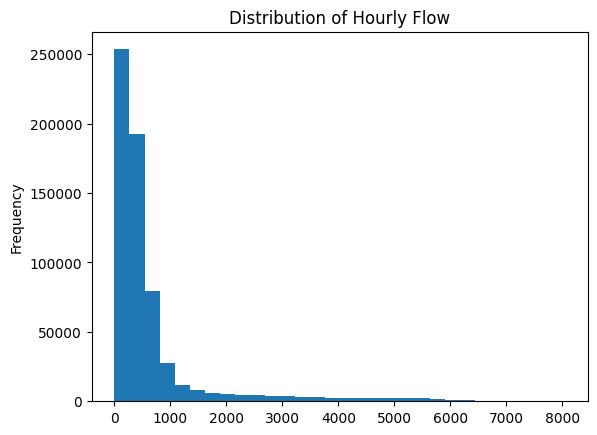

In [41]:
#visualization 
merged_df['Hourly Flow'].plot(kind='hist', bins=30, title='Distribution of Hourly Flow')


In [42]:
#categorical Columns 

categorical_columns = merged_df.select_dtypes(include='object').columns
print("Colonnes catégoriques identifiées :", categorical_columns)


Colonnes catégoriques identifiées : Index(['Label', 'Traffic State', 'Upstream Node Label',
       'Downstream Node Label', 'Arc State', 'geo_point_2d_x', 'geo_shape_x',
       'geo_point_2d_y', 'geo_shape_y', 'geometry_x', 'geometry_y',
       'x_geom_type', 'y_geom_type'],
      dtype='object')


In [43]:
print("Traffic State Distribution:")
print(merged_df['Traffic State'].value_counts())


Traffic State Distribution:
Traffic State
Inconnu       313069
Fluide        270136
Pré-saturé     28962
Saturé         11756
Bloqué          4313
Name: count, dtype: int64


In [44]:
for col in ['Arc State', 'Label', 'Upstream Node Label', 'Downstream Node Label']:
    print(f"{col} Distribution:")
    print(merged_df[col].value_counts())
    print("\n")


Arc State Distribution:
Arc State
Invalide    549888
Ouvert       64886
Barré        13462
Name: count, dtype: int64


Label Distribution:
Label
Pyrenees              6804
Bd_Ney                6615
Bd_Raspail            6615
Bd_Voltaire           6048
Tolbiac               6048
                      ... 
AI_A13_bretelle_3      189
AE_A13_bretelle_5      189
Romain_Rolland-A6A     189
Av_Kleber              189
Souterrain_Iena        189
Name: count, Length: 881, dtype: int64


Upstream Node Label Distribution:
Upstream Node Label
Pl_Charles_de_Gaulle         1890
Pl_Pte_d'Auteuil             1701
Rond_Point_Mirabeau          1512
Pte_Pantin-Av_Jean_Jaures    1323
Cours_la_Reine-Concorde      1323
                             ... 
La_Fayette-Montholon          189
Bassano-Av_Marceau            189
Ternes-Gouvion                189
AI_Asnieres                   189
Bd_Haussmann-Charras          189
Name: count, Length: 1631, dtype: int64


Downstream Node Label Distribution:
Downstream 

<Axes: >

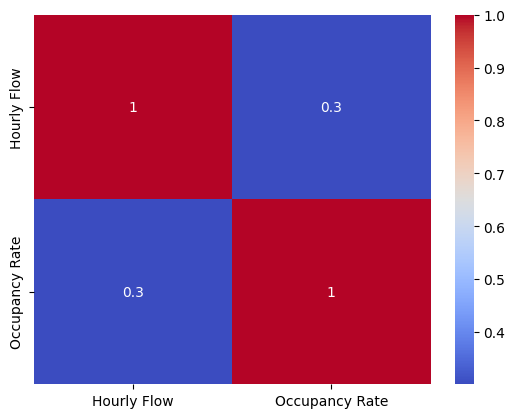

In [45]:
#Correlation Matrice 
correlation = merged_df[['Hourly Flow', 'Occupancy Rate']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')


<Axes: xlabel='Traffic State'>

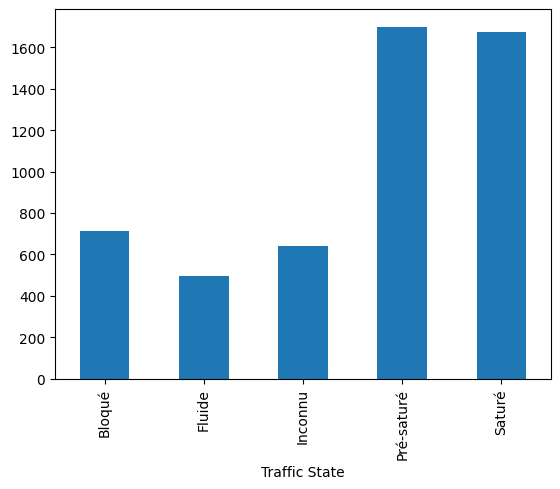

In [46]:
#Averages or medians of Hourly Flow by traffic state
merged_df.groupby('Traffic State')['Hourly Flow'].mean().plot(kind='bar')


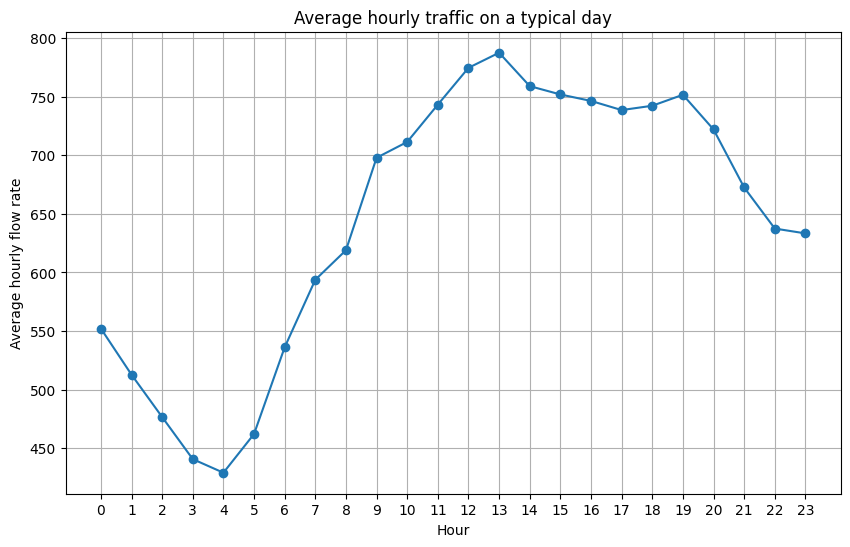

In [48]:
# Create columns for temporal analysis
merged_df['hour'] = merged_df['Counting DateTime'].dt.hour
merged_df['day_of_week'] = merged_df['Counting DateTime'].dt.day_name() 

#Average hourly traffic on a typical day
hourly_mean_flow = merged_df.groupby('hour')['Hourly Flow'].mean()

plt.figure(figsize=(10, 6))
hourly_mean_flow.plot(kind='line', marker='o', title='Average hourly traffic on a typical day')
plt.xlabel('Hour')
plt.ylabel('Average hourly flow rate')
plt.grid()
plt.xticks(range(0, 24))
plt.show()



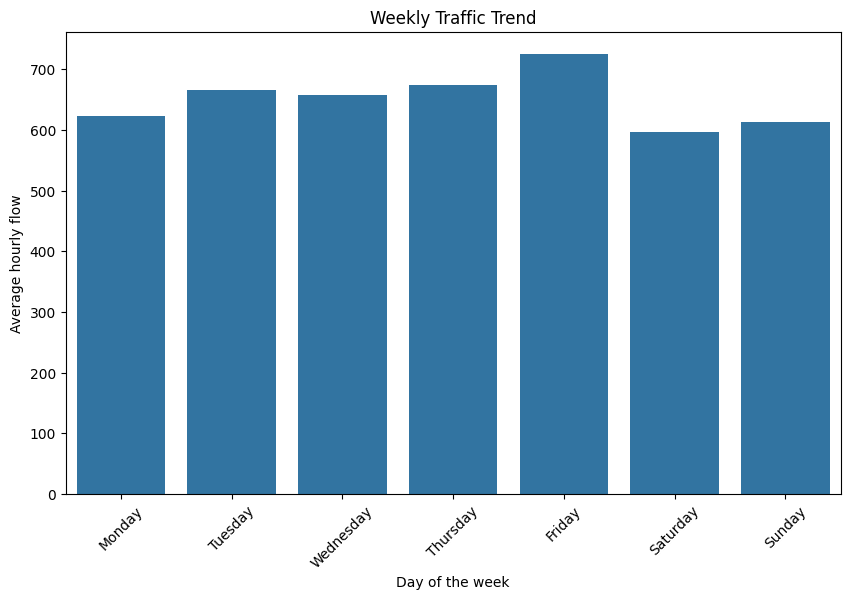

In [49]:
##Weekly Trend
weekly_mean_flow = merged_df.groupby('day_of_week')['Hourly Flow'].mean()
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
sns.barplot(x=weekly_mean_flow.index, y=weekly_mean_flow, order=order_days)
plt.title('Weekly Traffic Trend')
plt.xlabel('Day of the week')
plt.ylabel('Average hourly flow')
plt.xticks(rotation=45)
plt.show()

In [52]:
#Analysis of temporal outliers
top_5_busy_hours = merged_df.groupby('hour')['Hourly Flow'].mean().nlargest(5)
print("busy hours ", top_5_busy_hours)

Heures les plus chargées : hour
13    787.495404
12    774.593790
14    758.990150
15    751.877519
19    751.617127
Name: Hourly Flow, dtype: float64


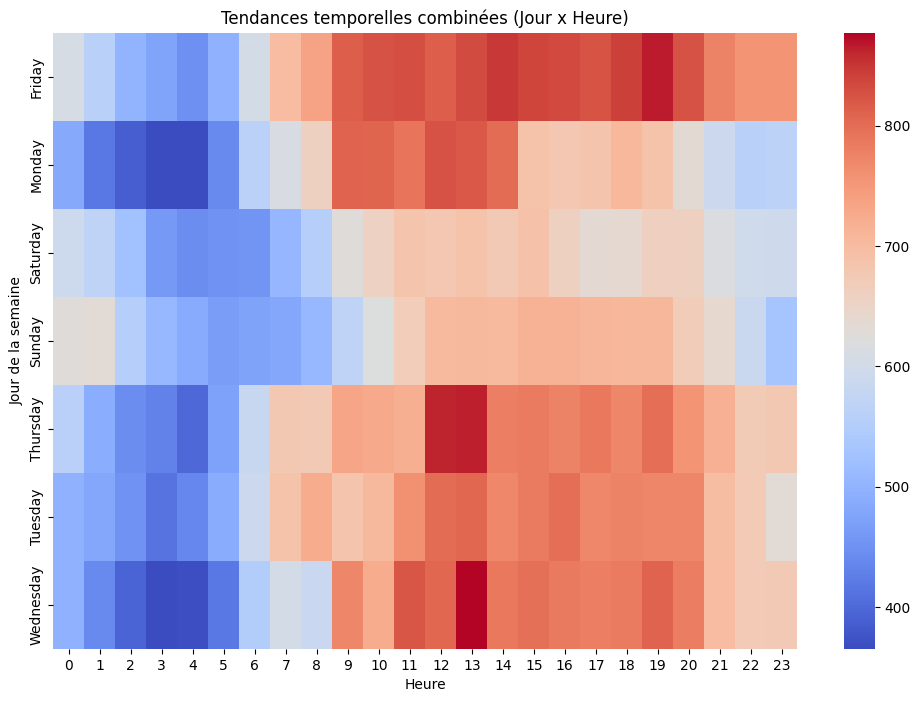

In [53]:
#Heatmap of combined time trends
heatmap_data = merged_df.pivot_table(
    index='day_of_week', columns='hour', values='Hourly Flow', aggfunc='mean'
)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False)
plt.title('Tendances temporelles combinées (Jour x Heure)')
plt.xlabel('Heure')
plt.ylabel('Jour de la semaine')
plt.show()


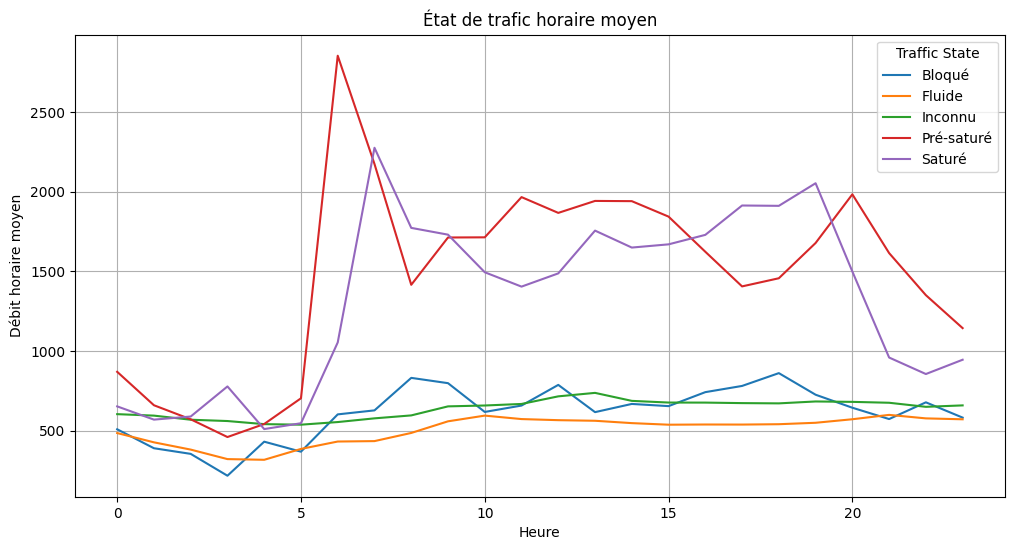

In [54]:
hourly_traffic_state = merged_df.groupby(['hour', 'Traffic State'])['Hourly Flow'].mean().unstack()

hourly_traffic_state.plot(kind='line', figsize=(12, 6), title='État de trafic horaire moyen')
plt.xlabel('Heure')
plt.ylabel('Débit horaire moyen')
plt.legend(title='Traffic State')
plt.grid()
plt.show()


## 5. Visualization
Using the cleaned data, we will create visualizations to identify patterns and trends.

## 6. Insights and Recommendations
Based on the analysis, we will summarize the main findings and propose actionable recommendations.